In [1]:
import scanpy as sc
import pandas as pd

In [2]:
# https://cellxgene.cziscience.com/e/ef1a4b05-540c-4f73-8ceb-49dfa800645d.cxg/
adata = sc.read_h5ad("/home/augusta/SSS_mount/insituCNV/data/lung_organoids_master.h5ad")

In [3]:
# Add raw layer
adata.layers['raw'] = adata.raw.X

In [4]:
adata.obs.donor_id.head(5)

N2_O1_AAACGAAAGTCGCCAC-1    R1
N2_O1_AAACGAAGTTAGCTAC-1    R1
N2_O1_AAACGAATCCTCTCTT-1    R1
N2_O1_AAACGCTCACTGCACG-1    R1
N2_O1_AAAGAACGTAGCTCGC-1    R1
Name: donor_id, dtype: category
Categories (2, object): ['R1', 'R2']

In [5]:
adata.obs.cell_type.head(5)

N2_O1_AAACGAAAGTCGCCAC-1    basal cell
N2_O1_AAACGAAGTTAGCTAC-1    basal cell
N2_O1_AAACGAATCCTCTCTT-1    basal cell
N2_O1_AAACGCTCACTGCACG-1    basal cell
N2_O1_AAAGAACGTAGCTCGC-1    basal cell
Name: cell_type, dtype: category
Categories (3, object): ['ciliated cell', 'secretory cell', 'basal cell']

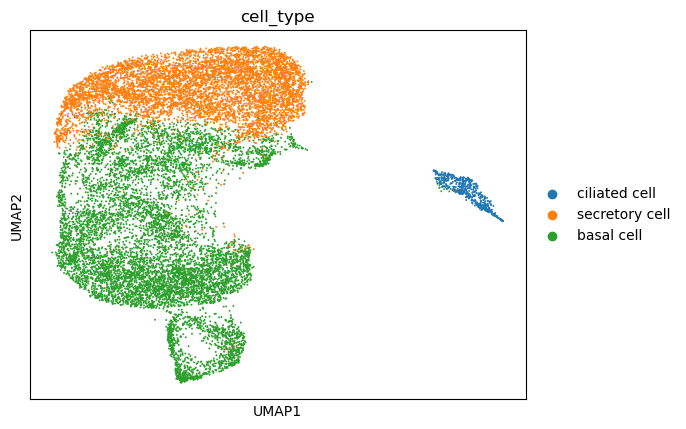

In [6]:
sc.pl.umap(adata, color = 'cell_type')

## Filter data
- one donor (R2)

In [7]:
adata = adata[adata.obs.donor_id == 'R2']

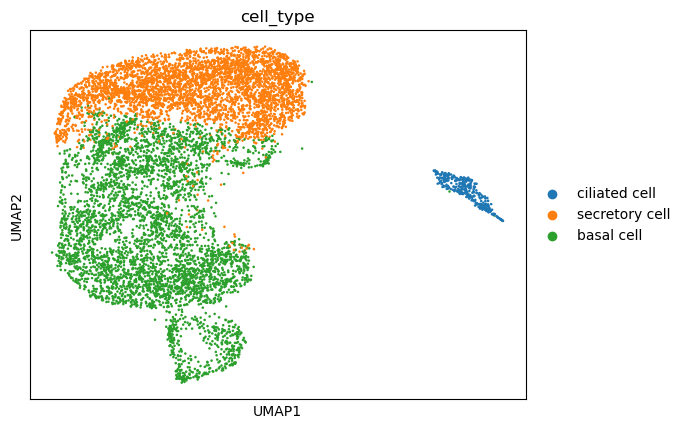

In [8]:
sc.pl.umap(adata, color = 'cell_type')

In [9]:
adata.var.head(5)

,gene_symbols,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,feature_type
gene_ids,,,,,,,
ENSG00000238009,AL627309.1,False,ENSG00000238009.6,NCBITaxon:9606,gene,629,lncRNA
ENSG00000241860,AL627309.5,False,ENSG00000241860.7,NCBITaxon:9606,gene,1025,lncRNA
ENSG00000241599,AL627309.4,False,ENSG00000241599.1,NCBITaxon:9606,gene,457,lncRNA
ENSG00000237491,LINC01409,False,LINC01409,NCBITaxon:9606,gene,1059,lncRNA
ENSG00000228794,LINC01128,False,LINC01128,NCBITaxon:9606,gene,1627,lncRNA


In [10]:
len(adata.var_names)

25691

In [12]:
# Remove genes that have been filtered
adata = adata[:, adata.var['feature_is_filtered']== False]

In [13]:
len(adata.var_names)

25691

In [14]:
# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, inplace=True)

/home/augusta/anaconda3/envs/scanpy_env/lib/python3.10/site-packages/scanpy/preprocessing/_qc.py:141: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


In [15]:
adata.var['total_counts'].mean()

1321.832382802753

In [16]:
adata.var.head(5)

,gene_symbols,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,feature_type,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
gene_ids,,,,,,,,,,,,,
ENSG00000238009,AL627309.1,False,ENSG00000238009.6,NCBITaxon:9606,gene,629,lncRNA,486,0.008812,0.008774,94.534413,78.360051,4.373995
ENSG00000241860,AL627309.5,False,ENSG00000241860.7,NCBITaxon:9606,gene,1025,lncRNA,581,0.010553,0.010498,93.466037,93.837299,4.552163
ENSG00000241599,AL627309.4,False,ENSG00000241599.1,NCBITaxon:9606,gene,457,lncRNA,7,0.000246,0.000246,99.921278,2.190479,1.160171
ENSG00000237491,LINC01409,False,LINC01409,NCBITaxon:9606,gene,1059,lncRNA,1591,0.035527,0.034910,82.107512,315.902356,5.758594
ENSG00000228794,LINC01128,False,LINC01128,NCBITaxon:9606,gene,1627,lncRNA,2011,0.042585,0.041704,77.384166,378.669894,5.939302


In [17]:
adata.var['n_cells_by_counts'].mean()

2540.8154995912964

In [18]:
adata.obs['total_counts'].mean()

3819.072845994774

## Add genomic positions

In [19]:

def add_genomic_positions(adata):
    ''' Adds gene positions to the AnnData object. The adata.var_names have to be EnsmblIDs. The data is taken from the Ensmbl BioMart human dataset GRCh38.p14. 

    param:
        adata (AnnData object): the annotated dataset where the gene postions should be added
    output: 
        adata (AnnData object): the annotated dataset where the genes are added
 
    '''

    
    # Load the gene positions data
    gene_file = "/home/augusta/SSS_mount/insituCNV/InSituCNV/Ensmbl_BioMart_gene_info.txt"
    gene_positions_df = pd.read_csv(gene_file)

    # Create a dictionary for quick lookup
    gene_dict = gene_positions_df.set_index("Gene stable ID")[["Chromosome/scaffold name", "Gene start (bp)", "Gene end (bp)"]].to_dict("index")

    # Format chromosome names
    format_chromosome = lambda x: f"chr{x}"

    # Initialize counters
    genes_identified = 0

    # Iterate over the genes in adata
    for gene_id in adata.var_names:
        if gene_id in gene_dict:
            info = gene_dict[gene_id]
            adata.var.loc[gene_id, ["chromosome", "start", "end"]] = [format_chromosome(info["Chromosome/scaffold name"]), info["Gene start (bp)"], info["Gene end (bp)"]]
            genes_identified += 1

    # Print summary of identified genes
    print(f"{genes_identified} gene positions identified \n{adata.shape[1] - genes_identified} were not found")
    return adata

In [20]:
add_genomic_positions(adata)

24824 gene positions identified 
867 were not found


AnnData object with n_obs × n_vars = 8892 × 25691
    obs: 'organism_ontology_term_id', 'tissue_ontology_term_id', 'tissue_type', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'donor_id', 'suspension_type', 'model_id', 'sample_id', 'Phase', 'level_1', 'level_2', 'level_3', 'CountUMIs', 'CountGenes', 'X.Mitochondrial', 'NoveltyScore', 'nCount_SCT', 'nFeature_SCT', 'orig.ident', 'is_primary_data', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_symbols', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_leng

# Selecting cells from one CNV cluster

### Running inferCNV

In [21]:
import scanpy as sc
import infercnvpy as cnv
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter("ignore")

sc.settings.set_figure_params(figsize=(5, 5))

/home/augusta/anaconda3/envs/scanpy_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
adata.layers['logcounts'] = adata.layers['raw'].copy()
sc.pp.normalize_total(adata, layer='logcounts')
sc.pp.log1p(adata, layer='logcounts')

In [23]:
adata.X = adata.layers['logcounts'].copy()

In [24]:
# We provide all immune cell types as "normal cells".
cnv.tl.infercnv(
    adata,
    window_size=100
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.92s/it]


In [25]:
cnv.tl.pca(adata)
cnv.pp.neighbors(adata)
cnv.tl.leiden(adata)

categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


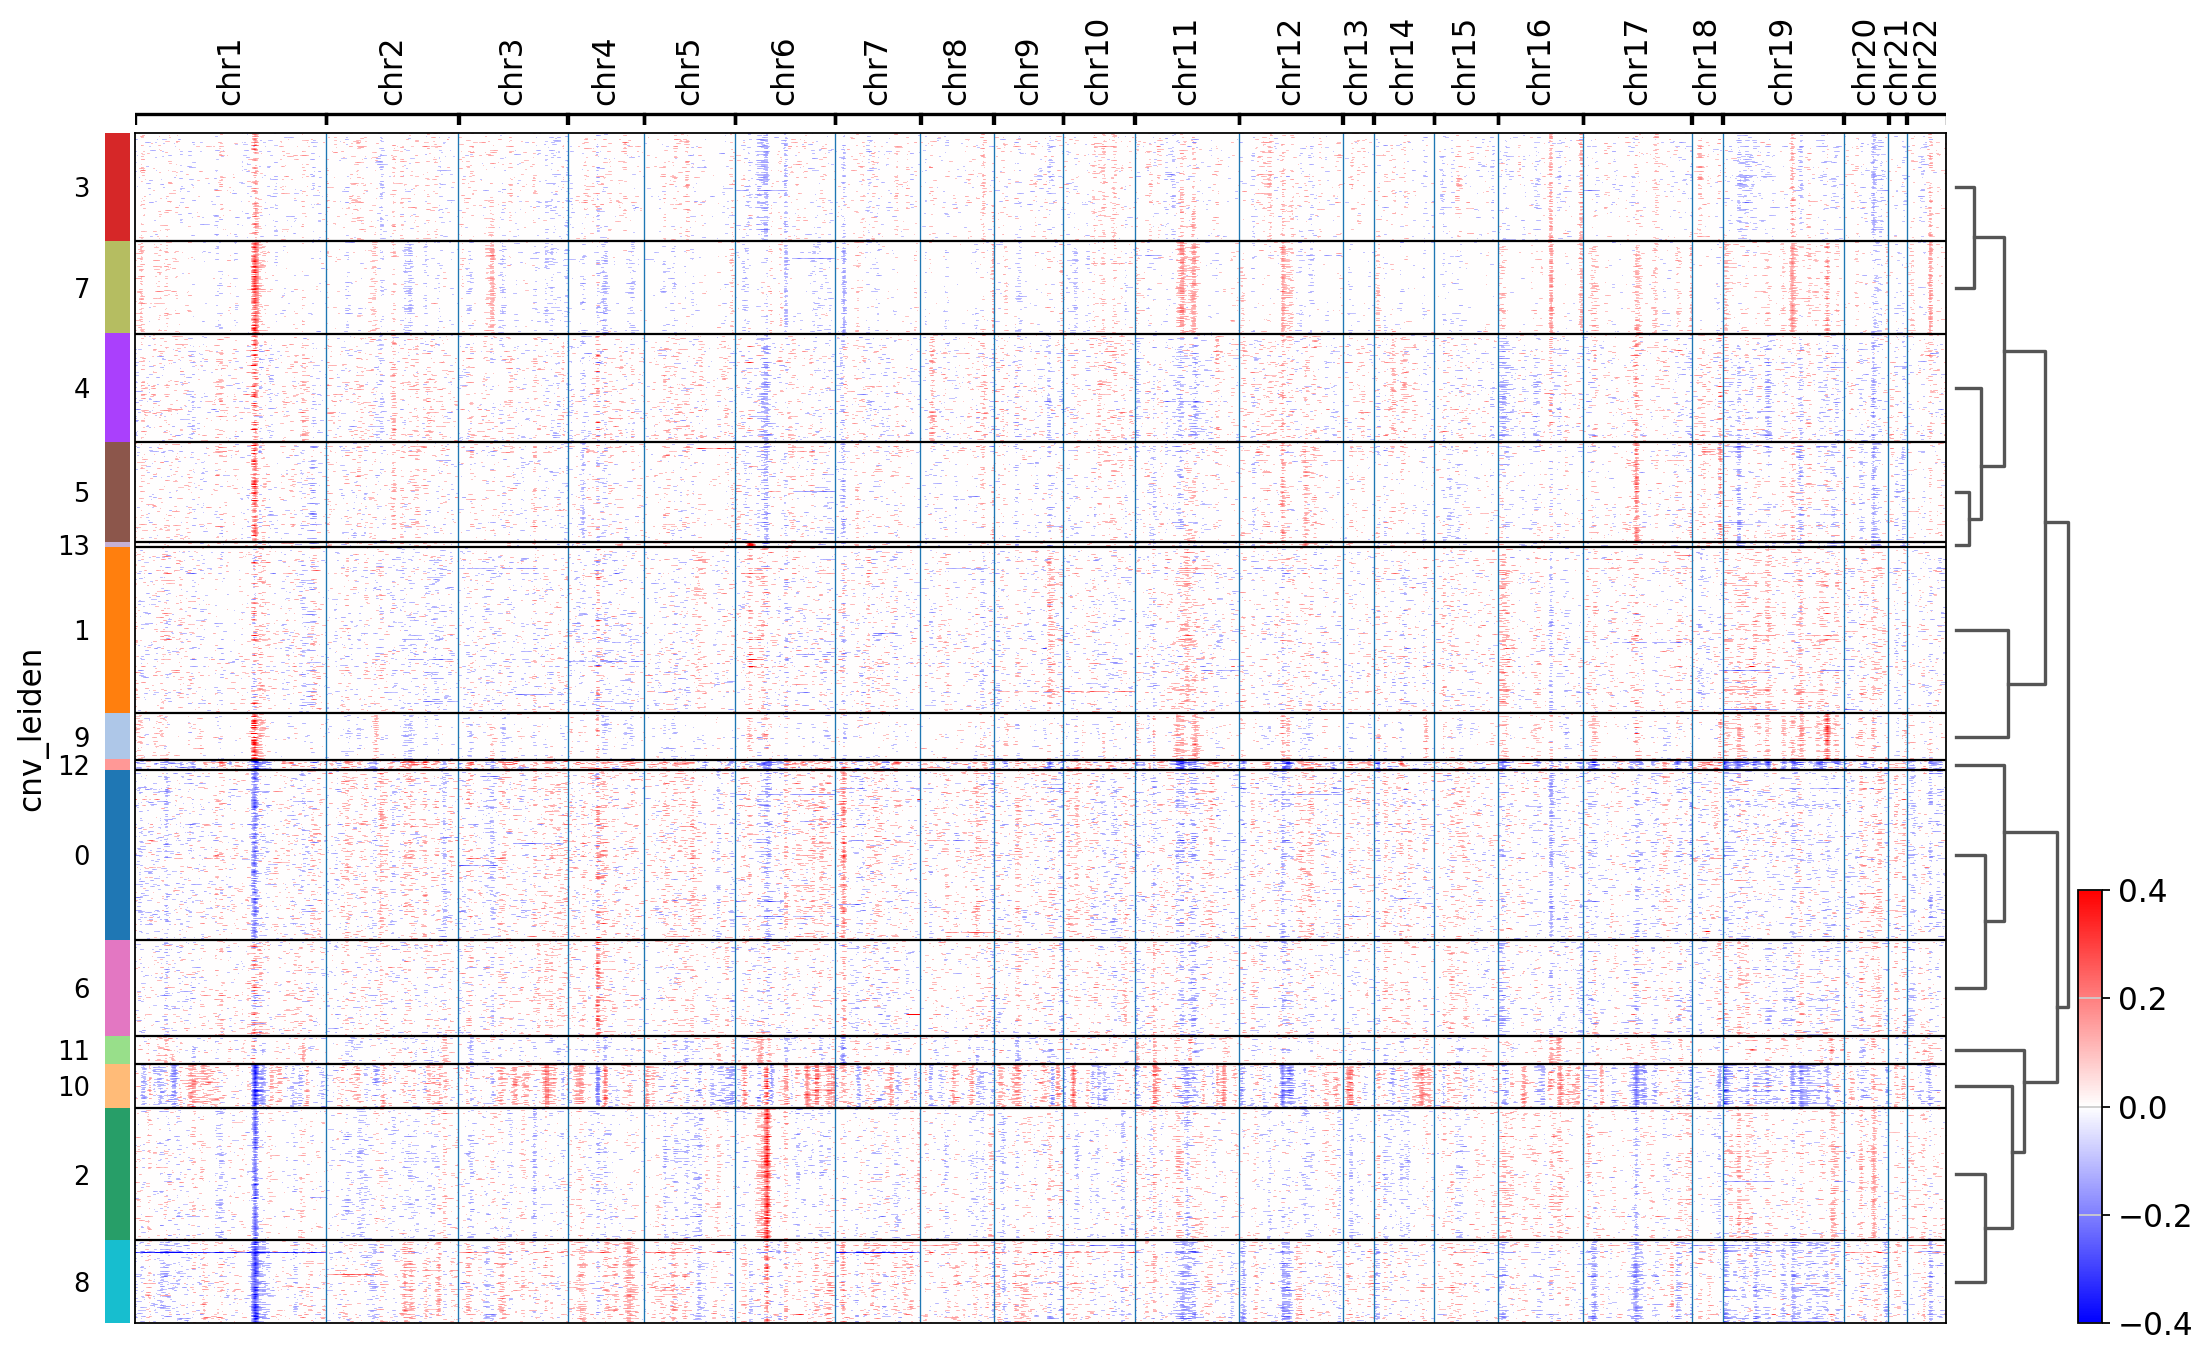

In [26]:
sc.tl.dendrogram(adata,groupby="cnv_leiden")
cnv.pl.chromosome_heatmap(adata, groupby="cnv_leiden", dendrogram=True, vmin=-0.4, vmax=0.4)

In [30]:
adata_sub = adata[adata.obs.cnv_leiden == '0']

# Saving AnnData

In [20]:
# adata_sub_filtered.write("/home/augusta/SSS_mount/insituCNV/data/lung_organoids.h5ad", compression = 'gzip')

In [31]:
adata_sub.write("/home/augusta/SSS_mount/insituCNV/data/lung_organoids_cnvclust.h5ad", compression = 'gzip')

... storing 'chromosome' as categorical
